In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

In [2]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [3]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [4]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [5]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

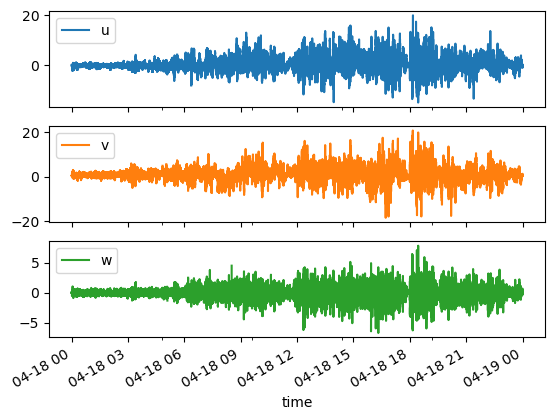

In [6]:
fast_df_sail[['u','v','w']].plot(subplots=True)

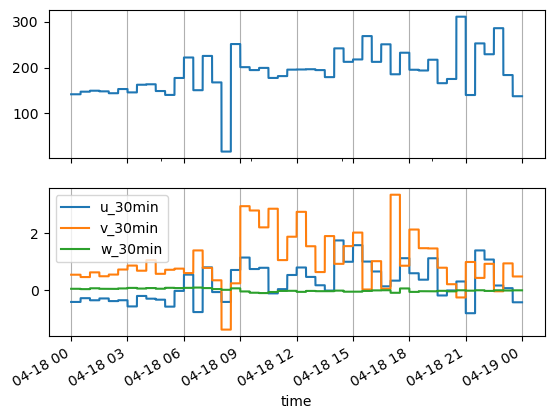

In [7]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)
fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [8]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.6627422676363955 -1.3167491586164178e-16 0.044493535598934056
Means after 2nd rotation: 0.6642341364473263 -1.3167491586164178e-16 -7.359878427225912e-18
Means after 1st rotation: 0.8527944779328487 2.2164201298737846e-17 0.06441814672567406
Means after 2nd rotation: 0.8552240169805396 2.2164201298737846e-17 1.4683783360413824e-17
Means after 1st rotation: 0.3466228872077543 1.0515459396712361e-17 0.05392742845514919
Means after 2nd rotation: 0.3507928070471582 1.0515459396712361e-17 1.7810559353181563e-17
Means after 1st rotation: 2.340778295079225 -4.2385792184335753e-16 -0.06551576260135725
Means after 2nd rotation: 2.3416949719942695 -4.2385792184335753e-16 8.61287649065936e-18
Means after 1st rotation: 1.6936754260593072 4.093285852166126e-16 -0.044984477469368275
Means after 2nd rotation: 1.694272720682939 4.093285852166126e-16 2.4016728214240026e-17
Means after 1st rotation: 1.4580727311206618 -3.5211537085241e-16 -0.027027934806548706
Means after 2nd

In [9]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [10]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [11]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 109000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 109000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 46.32it/s]


Got data of length 109969. using M = 16
Timestep of fast data is: 90.0 ms
Dataset of length 109969, with M = 16, permits 22 iterations.


100%|██████████| 22/22 [00:00<00:00, 14139.55it/s]


Got data of length 109006. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 109006, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 16522.30it/s]


Got data of length 108897. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108897, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17514.49it/s]


Got data of length 108874. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108874, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17483.20it/s]


Got data of length 108968. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108968, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 20603.60it/s]


Got data of length 108845. using M = 16
Timestep of fast data is: 70.0 ms
Dataset of length 108845, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 8501.97it/s]


Got data of length 108880. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108880, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 12069.11it/s]


In [12]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [13]:
daily_mrd_sail_chart = alt.Chart(
    mrd_uw_sail.reset_index().query("tau > 0")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sail')
daily_mrd_sail_chart

alt.Chart(...)

In [14]:
mrd_uw_sail['time range'] = mrd_uw_sail.start_time.astype(str) + ' - ' + mrd_uw_sail.end_time.astype(str)

In [15]:
alt.Chart(mrd_uw_sail.reset_index().query("tau > 0")).mark_line(strokeWidth=1).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('hour_group:O').scale(scheme='rainbow'),
    detail = 'time range'
).properties(width=300, height=300)

alt.Chart(...)

# SPLASH EC data

In [16]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [17]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [18]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

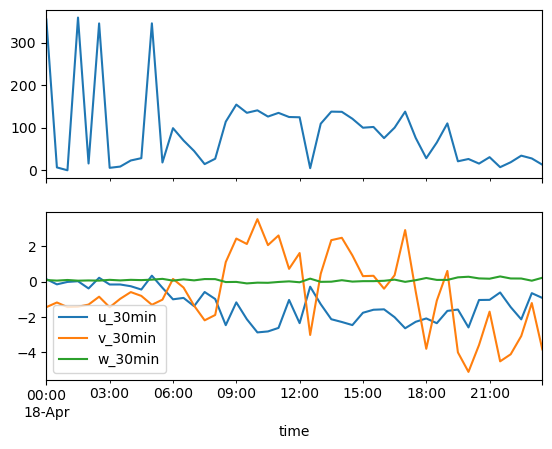

In [19]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [20]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.2666482748900492 -1.098831888759114e-16 0.0772666142960887
Means after 2nd rotation: 1.2690027509689321 -1.098831888759114e-16 4.226276495227362e-18
Means after 1st rotation: 1.0324662924246089 -1.266705712775666e-17 0.11195183171403797
Means after 2nd rotation: 1.0385181065427538 -1.266705712775666e-17 -4.486249399413817e-18
Means after 1st rotation: 1.428171009464732 2.957019466981188e-17 0.09460395440404679
Means after 2nd rotation: 1.431300925893781 2.957019466981188e-17 -3.3530488598804544e-17
Means after 1st rotation: 3.0867025680330658 -3.801882171832956e-16 -0.03322424124510729
Means after 2nd rotation: 3.0868813702033053 -3.801882171832956e-16 -5.5444115005897276e-18
Means after 1st rotation: 2.0051384174349507 -1.689725409703536e-16 0.04083325582150301
Means after 2nd rotation: 2.0055541448324257 -1.689725409703536e-16 2.125357741892729e-17
Means after 1st rotation: 2.0319159538937637 -1.6052391392183592e-16 0.05477563106018458
Means after 2nd rota

In [21]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [22]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [23]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5788.29it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 21716.07it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17203.20it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 19923.18it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17328.42it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 19127.12it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 15706.20it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


In [24]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [25]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

In [26]:
daily_mrd_splash_chart = alt.Chart(
    mrd_uw_splash.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='splash')
daily_mrd_splash_chart

alt.Chart(...)

# SOS EC data

Open data, average from 20hz to 10hz

In [27]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos = fast_data_files_to_dataframe(sos_file_list, rotation='none')

In [28]:
fast_df_sos = utils.modify_df_timezone(fast_df_sos, 'UTC', 'US/Mountain')
fast_df_sos = fast_df_sos.set_index('time').loc[DATE_LOCAL]

In [29]:
fast_df_sos = fast_df_sos[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [30]:
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

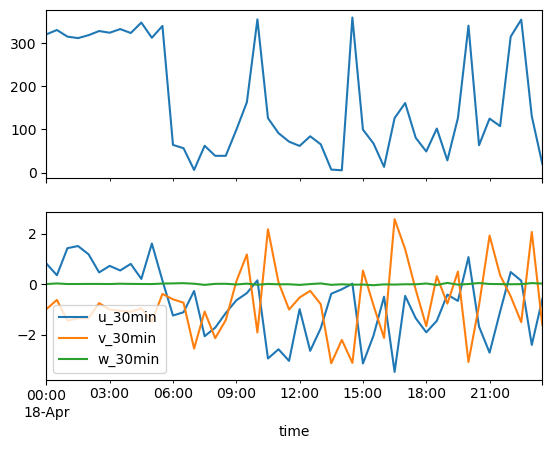

In [31]:
fast_df_sos_30min = fast_df_sos.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_sos_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [32]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.4472486 -3.051758e-08 0.0074909516
Means after 2nd rotation: 1.4472678 -3.051758e-08 1.165602e-09
Means after 1st rotation: 1.2023139 2.8257016e-08 0.008348804
Means after 2nd rotation: 1.202343 2.8257016e-08 1.2009232e-09
Means after 1st rotation: 1.9015547 -2.2605613e-08 0.011437975
Means after 2nd rotation: 1.9015889 -2.2605613e-08 -9.889956e-10
Means after 1st rotation: 1.5724633 1.3111256e-07 -0.0052673933
Means after 2nd rotation: 1.5724721 1.3111256e-07 -1.2892264e-09
Means after 1st rotation: 1.9473157 -8.251049e-08 -0.011317748
Means after 2nd rotation: 1.9473485 -8.251049e-08 5.651403e-10
Means after 1st rotation: 1.8408698 -9.94647e-08 -0.018046634
Means after 2nd rotation: 1.8409578 -9.94647e-08 -4.803693e-09
Means after 1st rotation: 1.2515265 -1.808449e-07 0.009646556
Means after 2nd rotation: 1.2515633 -1.808449e-07 1.9515003e-09
Means after 1st rotation: 1.0377959 9.042245e-08 0.00890773
Means after 2nd rotation: 1.037834 9.042245e-08 1.62477

In [33]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [34]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate MRD

In [35]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.55it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.56it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.56it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.60it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.85it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.69it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


In [36]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [37]:
alt.Chart(mrd_uw_sos.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

In [38]:
daily_mrd_sos_chart = alt.Chart(
    mrd_uw_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sos')
daily_mrd_sos_chart

alt.Chart(...)

In [39]:
(
    daily_mrd_splash_chart & daily_mrd_sail_chart & daily_mrd_sos_chart
).resolve_scale(
    color='independent',
    x='shared',
    y='shared'
)

alt.VConcatChart(...)